In [11]:
import importlib.util
import os

In [12]:
package_name = 'gymnasium'
if importlib.util.find_spec(package_name) is not None:
    print(package_name +" is installed")
else:
    print(package_name +" is installing")
    !pip install gymnasium

package_name = 'mpi4py'
if importlib.util.find_spec(package_name) is not None:
    print(package_name +" is installed")
else:
    print(package_name +" is installing")
    !pip install mpi4py

gymnasium is installed
mpi4py is installed


In [13]:
# if not os.path.isfile("Env_DG.py"):
#     !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/MBK/PPO/DG/Env_DG.py
# from Env_DG import MassSpringDamperEnv

if not os.path.isfile("PPO_utilz_DG.py"):
    !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/MBK/PPO/DG/PPO_utilz_DG.py
from PPO_utilz_DG import *
# 
# if not os.path.isfile("PPO_DG.py"):
#     !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/MBK/PPO/DG/PPO_DG.py
# from PPO_DG import PPO

In [14]:
from PPO_utilz_DG import *
import os.path as osp, atexit, os
import sys
import time
import json
import string
import base64
import warnings
import psutil
import zlib
import subprocess
from textwrap import dedent
from subprocess import CalledProcessError

# Third-party imports
import numpy as np
import joblib
import cloudpickle
import scipy.signal
import matplotlib.pyplot as plt
from tqdm import trange
from mpi4py import MPI
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from gymnasium import spaces

# PyTorch imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical


class PPOBuffer:
    """
    A buffer for storing trajectories experienced by a PPO agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size
        # add second player
        self.act_buf_2 = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf_2 = np.zeros(size, dtype=np.float32)
        self.rew_buf_2 = np.zeros(size, dtype=np.float32)
        self.ret_buf_2 = np.zeros(size, dtype=np.float32)
        self.val_buf_2 = np.zeros(size, dtype=np.float32)
        self.logp_buf_2 = np.zeros(size, dtype=np.float32)

    def store(self, obs, act, rew, val, logp, act_2, rew_2, val_2, logp_2):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size  # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        # add second player
        self.act_buf_2[self.ptr] = act_2
        self.rew_buf_2[self.ptr] = rew_2
        self.val_buf_2[self.ptr] = val_2
        self.logp_buf_2[self.ptr] = logp_2
        self.ptr += 1

    def finish_path(self, last_val=0, last_val_2=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.

        The "last_val" argument should be zero if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        # add second player
        rews_2 = np.append(self.rew_buf_2[path_slice], last_val_2)
        vals_2 = np.append(self.val_buf_2[path_slice], last_val_2)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)
        # add second player
        deltas_2 = rews_2[:-1] + self.gamma * vals_2[1:] - vals_2[:-1]
        self.adv_buf_2[path_slice] = discount_cumsum(deltas_2, self.gamma * self.lam)

        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]
        # add second player
        self.ret_buf_2[path_slice] = discount_cumsum(rews_2, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size  # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = mpi_statistics_scalar(self.adv_buf)
        # add second player
        adv_mean_2, adv_std_2 = mpi_statistics_scalar(self.adv_buf_2)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        # add second player
        self.adv_buf_2 = (self.adv_buf_2 - adv_mean_2) / adv_std_2
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf, act_2=self.act_buf_2,
                    ret_2=self.ret_buf_2, adv_2=self.adv_buf_2, logp_2=self.logp_buf_2)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}


In [15]:
class PPO:
    def __init__(self, env, ac_kwargs=None, seed=0,
                 steps_per_epoch=4000, epochs=50, gamma=0.99, clip_ratio=0.2, pi_lr=3e-4,
                 vf_lr=1e-3, train_pi_iters=80, train_v_iters=80, lam=0.97, max_ep_len=1000,
                 target_kl=0.01, logger_kwargs=None, save_freq=10):
        self.env = env
        self.ac_kwargs = ac_kwargs or {}
        self.seed = seed
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.pi_lr = pi_lr
        self.vf_lr = vf_lr
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.lam = lam
        self.max_ep_len = max_ep_len
        self.target_kl = target_kl
        self.logger_kwargs = logger_kwargs or {}
        setup_pytorch_for_mpi()
        self.save_freq = save_freq
        self.second_player = True
        """
            Proximal Policy Optimization (by clipping),

            with early stopping based on approximate KL

            Args:
                env : The environment must satisfy the OpenAI Gym API.

                actor_critic: The constructor method for a PyTorch Module with a
                    ``step`` method, an ``act`` method, a ``pi`` module, and a ``v``
                    module. The ``step`` method should accept a batch of observations
                    and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``a``        (batch, act_dim)  | Numpy array of actions for each
                                                   | observation.
                    ``v``        (batch,)          | Numpy array of value estimates
                                                   | for the provided observations.
                    ``logp_a``   (batch,)          | Numpy array of log probs for the
                                                   | actions in ``a``.
                    ===========  ================  ======================================

                    The ``act`` method behaves the same as ``step`` but only returns ``a``.

                    The ``pi`` module's forward call should accept a batch of
                    observations and optionally a batch of actions, and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``pi``       N/A               | Torch Distribution object, containing
                                                   | a batch of distributions describing
                                                   | the policy for the provided observations.
                    ``logp_a``   (batch,) | Optional (only returned if batch of
                                                   | actions is given). Tensor containing
                                                   | the log probability, according to
                                                   | the policy, of the provided actions.
                                                   | If actions not given, will contain
                                                   | ``None``.
                    ===========  ================  ======================================

                    The ``v`` module's forward call should accept a batch of observations
                    and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``v``        (batch,)          | Tensor containing the value estimates
                                                   | for the provided observations. (Critical:
                                                   | make sure to flatten this!)
                    ===========  ================  ======================================


                ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object
                    you provided to PPO.

                seed (int): Seed for random number generators.

                steps_per_epoch (int): Number of steps of interaction (state-action pairs)
                    for the agent and the environment in each epoch.

                epochs (int): Number of epochs of interaction (equivalent to
                    number of policy updates) to perform.

                gamma (float): Discount factor. (Always between 0 and 1.)

                clip_ratio (float): Hyperparameter for clipping in the policy objective.
                    Roughly: how far can the new policy go from the old policy while
                    still profiting (improving the objective function)? The new policy
                    can still go farther than the clip_ratio says, but it doesn't help
                    on the objective anymore. (Usually small, 0.1 to 0.3.) Typically
                    denoted by :math:`\epsilon`.

                pi_lr (float): Learning rate for policy optimizer.

                vf_lr (float): Learning rate for value function optimizer.

                train_pi_iters (int): Maximum number of gradient descent steps to take
                    on policy loss per epoch. (Early stopping may cause optimizer
                    to take fewer than this.)

                train_v_iters (int): Number of gradient descent steps to take on
                    value function per epoch.

                lam (float): Lambda for GAE-Lambda. (Always between 0 and 1,
                    close to 1.)

                max_ep_len (int): Maximum length of trajectory / episode / rollout.

                target_kl (float): Roughly what KL divergence we think is appropriate
                    between new and old policies after an update. This will get used
                    for early stopping. (Usually small, 0.01 or 0.05.)

                logger_kwargs (dict): Keyword args for EpochLogger.

                save_freq (int): How often (in terms of gap between epochs) to save
                    the current policy and value function.

            """
        # Set up logger and save configuration
        self.logger = EpochLogger(**self.logger_kwargs)
        self.logger.save_config(locals())

        # Random seed
        self.seed += 10000 * proc_id()
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Instantiate environment
        obs_dim = self.env.observation_space.shape
        act_dim = self.env.action_space.shape

        # Create actor-critic module
        self.ac = MLPActorCritic(self.env.observation_space, self.env.action_space, **self.ac_kwargs)
        # add second player
        self.ac_2 = MLPActorCritic(self.env.observation_space, self.env.action_space, **self.ac_kwargs)

        # Sync params across processes
        sync_params(self.ac)
        sync_params(self.ac_2)

        # Count variables
        var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.v])
        self.logger.log('\nNumber of parameters 😱😱😱: \t pi: %d, \t v: %d\n' % var_counts)

        # Set up experience buffer
        self.local_steps_per_epoch = int(steps_per_epoch / num_procs())
        self.buf = PPOBuffer(obs_dim, act_dim, self.local_steps_per_epoch, gamma, lam)

        # Set up optimizers for policy and value function
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = Adam(self.ac.v.parameters(), lr=vf_lr)
        # add second player
        self.pi_optimizer_2 = Adam(self.ac_2.pi.parameters(), lr=pi_lr)
        self.vf_optimizer_2 = Adam(self.ac_2.v.parameters(), lr=vf_lr)

        # Set up model saving
        self.logger.setup_pytorch_saver(self.ac)

    # Set up function for computing PPO policy loss
    def compute_loss_pi(self, data, actor_no='player_1'):
        if actor_no == 'player_1':
            obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']
            pi, logp = self.ac.pi(obs, act)
        else:
            obs, act, adv, logp_old = data['obs'], data['act_2'], data['adv_2'], data['logp_2']
            pi, logp = self.ac_2.pi(obs, act)

        # Policy loss
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1 + self.clip_ratio) | ratio.lt(1 - self.clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, data, actor_no='player_1'):
        if actor_no == 'player_1':
            obs, ret = data['obs'], data['ret']
            return ((self.ac.v(obs) - ret) ** 2).mean()
        else:
            obs, ret = data['obs'], data['ret_2']
            return ((self.ac_2.v(obs) - ret) ** 2).mean()

    def update(self):
        data = self.buf.get()

        pi_l_old, pi_info_old = self.compute_loss_pi(data)  # Loss pi before
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(data).item()
        # add second player
        pi_l_old_2, pi_info_old_2 = self.compute_loss_pi(data, actor_no='player_2')  # Loss pi before
        pi_l_old_2 = pi_l_old_2.item()
        v_l_old_2 = self.compute_loss_v(data, actor_no='player_2').item()

        # Train policy with multiple steps of gradient descent
        for i in range(self.train_pi_iters):
            self.pi_optimizer.zero_grad()
            loss_pi, pi_info = self.compute_loss_pi(data)
            kl = mpi_avg(pi_info['kl'])
            if kl > 1.5 * self.target_kl:
                self.logger.log('Early stopping at step %d due to reaching max kl for 1th player.' % i)
                break
            loss_pi.backward()
            mpi_avg_grads(self.ac.pi)  # average grads across MPI processes
            self.pi_optimizer.step()
        # add second player
        for i in range(self.train_pi_iters):
            self.pi_optimizer_2.zero_grad()
            loss_pi_2, pi_info_2 = self.compute_loss_pi(data, actor_no='player_2')
            kl_2 = mpi_avg(pi_info_2['kl'])
            if kl_2 > 1.5 * self.target_kl:
                self.logger.log_2('Early stopping at step %d due to reaching max kl for 2th player.' % i)
                break
            loss_pi_2.backward()
            mpi_avg_grads(self.ac_2.pi)  # average grads across MPI processes
            self.pi_optimizer_2.step()

        self.logger.store(StopIter=i)

        # Value function learning
        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self.compute_loss_v(data)
            loss_v.backward()
            mpi_avg_grads(self.ac.v)  # average grads across MPI processes
            self.vf_optimizer.step()
        # add second player
        for i in range(self.train_v_iters):
            self.vf_optimizer_2.zero_grad()
            loss_v_2 = self.compute_loss_v(data, actor_no='player_2')
            loss_v_2.backward()
            mpi_avg_grads(self.ac_2.v)  # average grads across MPI processes
            self.vf_optimizer_2.step()

        # Log changes from update
        kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        # add second player
        kl_2, ent_2, cf_2 = pi_info_2['kl'], pi_info_old_2['ent'], pi_info_2['cf']
        self.logger.store(LossPi=pi_l_old, LossV=v_l_old,
                          KL=kl, Entropy=ent, ClipFrac=cf,
                          DeltaLossPi=(loss_pi.item() - pi_l_old),
                          DeltaLossV=(loss_v.item() - v_l_old),  # add second player
                          LossPi_2=pi_l_old_2, LossV_2=v_l_old_2,
                          KL_2=kl_2, Entropy_2=ent_2, ClipFrac_2=cf_2,
                          DeltaLossPi_2=(loss_pi_2.item() - pi_l_old_2),
                          DeltaLossV_2=(loss_v_2.item() - v_l_old_2))

    def train(self):
        # Prepare for interaction with environment
        start_time = time.time()
        o, _ = self.env.reset()
        ep_ret, ep_len = 0, 0
        ep_ret_2, ep_len_2 = 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for epoch in range(self.epochs):
            for t in range(self.local_steps_per_epoch):
                a, v, logp = self.ac.step(torch.as_tensor(o, dtype=torch.float32))
                # add second player
                a_2, v_2, logp_2 = self.ac_2.step(torch.as_tensor(o, dtype=torch.float32))

                action = [a.item(), a_2.item() if self.second_player else 0]
                next_o, r, d, _, _, r_2 = self.env.step(action)
                ep_ret += r
                ep_len += 1
                ep_ret_2 += r_2
                ep_len_2 += 1

                # save and log
                self.buf.store(o, a, r, v, logp, a_2, r_2, v_2, logp_2)
                self.logger.store(VVals=v, VVals_2=v_2)

                # Update obs (critical!)
                o = next_o

                timeout = ep_len == self.max_ep_len
                terminal = d or timeout
                epoch_ended = t == self.local_steps_per_epoch - 1

                if terminal or epoch_ended:
                    if epoch_ended and not terminal:
                        print('Warning: trajectory cut off by epoch at %d steps.' % ep_len, flush=True)
                    # if trajectory didn't reach terminal state, bootstrap value target
                    if timeout or epoch_ended:
                        _, v, _ = self.ac.step(torch.as_tensor(o, dtype=torch.float32))
                        _, v_2, _ = self.ac_2.step(torch.as_tensor(o, dtype=torch.float32))
                    else:
                        v = 0
                        v_2 = 0
                    self.buf.finish_path(v, v_2)
                    if terminal:
                        # only save EpRet / EpLen if the trajectory finished
                        self.logger.store(EpRet=ep_ret, EpLen=ep_len, EpRet_2=ep_ret_2, EpLen_2=ep_len_2)
                    o, _ = self.env.reset()
                    ep_ret, ep_len = 0, 0
                    ep_ret_2, ep_len_2 = 0, 0

            # Save model
            if (epoch % self.save_freq == 0) or (epoch == self.epochs - 1):
                self.logger.save_state({'env': self.env}, None)

            # Perform PPO update!
            self.update()

            # Log info about epoch
            self.logger.log_tabular('Epoch', epoch)
            self.logger.log_tabular('EpRet', with_min_and_max=True)
            self.logger.log_tabular('EpLen', average_only=True)
            self.logger.log_tabular('VVals', with_min_and_max=True)
            self.logger.log_tabular('TotalEnvInteracts', (epoch + 1) * self.steps_per_epoch)
            self.logger.log_tabular('LossPi', average_only=True)
            self.logger.log_tabular('LossV', average_only=True)
            self.logger.log_tabular('DeltaLossPi', average_only=True)
            self.logger.log_tabular('DeltaLossV', average_only=True)
            self.logger.log_tabular('Entropy', average_only=True)
            self.logger.log_tabular('KL', average_only=True)
            self.logger.log_tabular('ClipFrac', average_only=True)
            # add second player
            self.logger.log_tabular('EpRet_2', with_min_and_max=True)
            self.logger.log_tabular('EpLen_2', average_only=True)
            self.logger.log_tabular('VVals_2', with_min_and_max=True)
            self.logger.log_tabular('LossPi_2', average_only=True)
            self.logger.log_tabular('LossV_2', average_only=True)
            self.logger.log_tabular('DeltaLossPi_2', average_only=True)
            self.logger.log_tabular('DeltaLossV_2', average_only=True)
            self.logger.log_tabular('Entropy_2', average_only=True)
            self.logger.log_tabular('KL_2', average_only=True)
            self.logger.log_tabular('ClipFrac_2', average_only=True)

            self.logger.log_tabular('StopIter', average_only=True)
            self.logger.log_tabular('Time', time.time() - start_time)
            self.logger.dump_tabular()

    def test(self, fun_mode=False, deterministic=True):
        o, _ = self.env.reset()
        states = []
        actions = []
        actions_2 = []
        while True:
            a, _, _ = self.ac.step(torch.as_tensor(o, dtype=torch.float32), deterministic=deterministic)
            a_2, _, _ = self.ac_2.step(torch.as_tensor(o, dtype=torch.float32), deterministic=deterministic)
            actions.append(a * 20)
            actions_2.append(a_2 * 20)
            action = [a.item(), a_2.item() if self.second_player else 0]
            o, _, d, _, _, _ = self.env.step(action)
            states.append(o * 40 - 20)
            if d:
                break
        dt = self.env.dt
        time = np.arange(0, len(states) * dt, dt)

        if fun_mode:
            # Use XKCD style for hand-drawn look
            with plt.xkcd():
                plt.plot(time, states)
                plt.xlabel("Time (sec)")
                plt.ylabel("State")
                plt.legend(["position", "velocity", "integral error"])
                plt.show()
            with plt.xkcd():
                plt.plot(time, actions)
                plt.xlabel("Time (sec)")
                plt.ylabel("first action (N)")
                plt.show()
            # add second player
            with plt.xkcd():
                plt.plot(time, actions_2)
                plt.xlabel("Time (sec)")
                plt.ylabel("second action (N)")
        else:
            plt.plot(time, states)
            plt.xlabel("Time (sec)")
            plt.ylabel("State")
            plt.legend(["position", "velocity", "integral error"])
            plt.show()

            plt.plot(time, actions)
            plt.xlabel("Time (sec)")
            plt.ylabel("first action (N)")
            plt.show()

            plt.plot(time, actions_2)
            plt.xlabel("Time (sec)")
            plt.ylabel("second action (N)")
            plt.show()

    # save actor critic
    def save(self, filepath='model/actor_critic_torch.pth'):
        if not os.path.exists('model/'):
            os.makedirs('model/')
        torch.save({
            'actor_state_dict': self.ac.pi.state_dict(),
            'critic_state_dict': self.ac.v.state_dict(),
        }, filepath)
        print(colorize(f"Model saved to {filepath} 🔥🪐🥺🤭", 'green'))
        # add second player
        torch.save({
            'actor_state_dict': self.ac_2.pi.state_dict(),
            'critic_state_dict': self.ac_2.v.state_dict(),
        }, filepath.replace('.pth', '_2.pth'))

    # load actor critic
    def load(self, filepath='model/actor_critic_torch.pth'):
        checkpoint = torch.load(filepath)
        self.ac.pi.load_state_dict(checkpoint['actor_state_dict'])
        self.ac.v.load_state_dict(checkpoint['critic_state_dict'])
        print(colorize(f"Model loaded from {filepath} 🔥😎😌🥰", 'green'))

    def load_2(self, filepath='model/actor_critic_torch_2.pth'):
        checkpoint = torch.load(filepath)
        self.ac_2.pi.load_state_dict(checkpoint['actor_state_dict'])
        self.ac_2.v.load_state_dict(checkpoint['critic_state_dict'])
        print(colorize(f"Model loaded from {filepath} 🔥😎😌🥰", 'green'))


In [16]:
# Third-party imports
import numpy as np

import gymnasium as gym
import logging

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


class MassSpringDamperEnv(gym.Env):

    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.step_num = None
        self.last_u = None
        self.state = None
        self.done = None
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # Integrator
        self.integral_error = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-20.0, high=20.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-100, high=100, shape=(2,))

    def step(self, action):
        # clip action
        np.clip(action, -1, 1)
        action_1 = action[0] * 0
        action_2 = action[1] if len(action) > 1 else None
        # Apply control action and simulate one time step using Euler integration
        force = (action_1 + action_2) * self.action_space.high[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.integral_error += position * self.dt

        # Linear quadratic differential game cost
        costs = (position ** 2 + 0.1 * velocity ** 2 + 0.01 * self.integral_error ** 2 +
                 0.001 * (action_1 ** 2) - 0.001 * (action_2 ** 2)) * self.dt

        self.step_num += 1
        if self.step_num > 1000:
            self.done = True

        # early stop
        if sum(self.state > 20) > 0 or sum(self.state < -20) > 0:
            self.done = True
            costs += 10

        # second player cost
        costs_2 = -costs

        return self._get_obs(), -costs, self.done, False, {}, -costs_2

    def reset(self):
        self.state = np.random.uniform(low=-10, high=10, size=(2,))
        self.current_step = 0
        self.last_u = None
        self.done = False
        self.step_num = 0
        self.integral_error = 0

        return self._get_obs(), {}

    def _get_obs(self):
        position, velocity = (self.state + self.action_space.high[0]) / (
                    self.action_space.high[0] - self.action_space.low[0])  # normalized data
        return np.array([position, velocity], dtype=np.float32)


In [17]:
# Define constants
HID = 64
L = 2
GAMMA = 0.99
SEED = 0
STEPS = 4000
EPOCHS = 216
EXP_NAME = 'PPO_MBK_DG'
logger_kwargs = setup_logger_kwargs(EXP_NAME, SEED)

In [18]:
# Proximal Policy Optimization
ppo = PPO(MassSpringDamperEnv(), ac_kwargs=dict(hidden_sizes=[HID] * L), gamma=GAMMA,
            seed=SEED, steps_per_epoch=STEPS, epochs=EPOCHS,
            logger_kwargs=logger_kwargs)

Logging data to /Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/MBK/PPO/DG/data/PPO_MBK_DG/PPO_MBK_DG_s0/progress.txt
Saving config:


Number of parameters 😱😱😱: 	 pi: 4418, 	 v: 4417



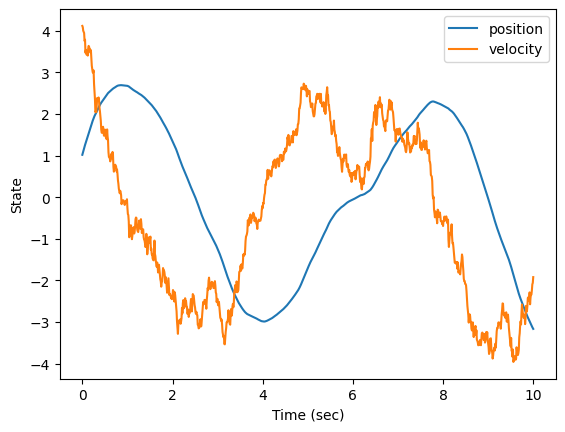

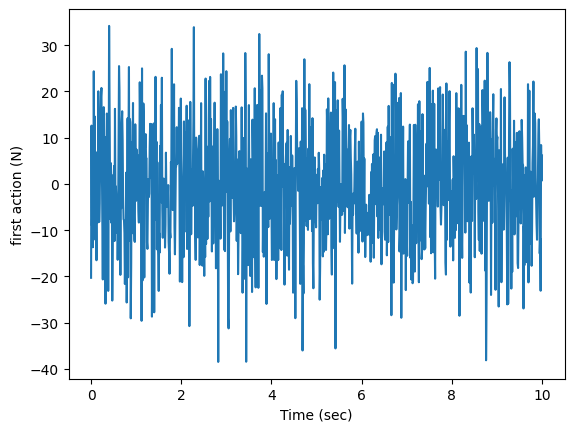

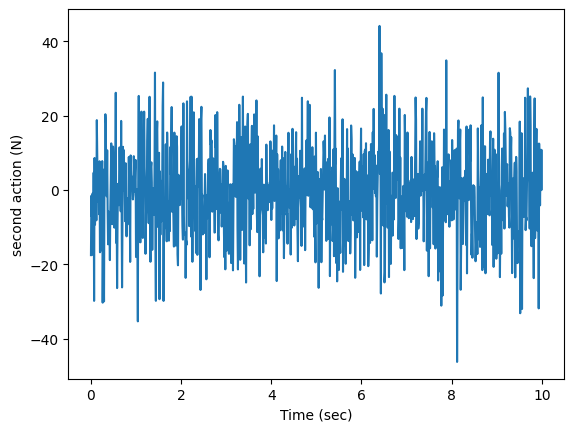

In [19]:
# test PPO agent (not trained)
ppo.test(deterministic=False)

In [20]:
ppo.second_player = True
ppo.train()

---------------------------------------
|             Epoch |               0 |
|      AverageEpRet |            -226 |
|          StdEpRet |             167 |
|          MaxEpRet |           -74.4 |
|          MinEpRet |            -495 |
|             EpLen |           1e+03 |
|      AverageVVals |          -0.027 |
|          StdVVals |           0.018 |
|          MaxVVals |            0.01 |
|          MinVVals |         -0.0681 |
| TotalEnvInteracts |           4e+03 |
|            LossPi |       -9.06e-09 |
|             LossV |             753 |
|       DeltaLossPi |        -0.00244 |
|        DeltaLossV |            -294 |
|           Entropy |           0.919 |
|                KL |         0.00304 |
|          ClipFrac |          0.0322 |
---------------------------------------
⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️⚔️
|    AverageEpRet_2 |             226 |
|        StdEpRet_2 |             167 |
|        MaxEpRet_2 |             495 |
|        MinEpRet_2 |            74.4 |
|

KeyboardInterrupt: 

In [ ]:
ppo.test()

In [ ]:
try:
    import google.colab
    # download created models
    if os.path.isfile("results.tar.gz"):
        os.remove("results.tar.gz")
    !tar cvfz results.tar.gz model/ data/
    from google.colab import files
    files.download('results.tar.gz')
    print(colorize("Done! 🥰😎", 'blue', bold=True))
except:
    print(colorize("Something Wrong 🧐😩, or maybe you used your Mac 😱🥲", 'red', bold=True))